### Analytical Solution

The displacement solution due to a moment tensor source $M_{jk}$ in a homogeneous, isotropic elastic medium is (Aki & Richards, 2002): 


\begin{equation}
\begin{aligned}
u_i(\mathbf{r}, t) &=\frac{1}{4 \pi \rho} \frac{A^N}{r^4} \int_{r / V_{\mathrm{P}}}^{r / V_{\mathrm{S}}} \tau M_{j k}(t-\tau) d \tau+\frac{1}{4 \pi \rho V_{\mathrm{P}}^2} \frac{A^{\mathrm{IP}}}{r^2} M_{j k}\left(t-\frac{r}{V_{\mathrm{P}}}\right) \\
&+\frac{1}{4 \pi \rho V_{\mathrm{S}}^2} \frac{A^{\mathrm{IS}}}{r^2} M_{j k}\left(t-\frac{r}{V_{\mathrm{S}}}\right)+\frac{1}{4 \pi \rho V_{\mathrm{P}}^3} \frac{A^{\mathrm{FP}}}{r} \dot{M}_{j k}\left(t-\frac{r}{V_{\mathrm{P}}}\right) \\
&+\frac{1}{4 \pi \rho V_{\mathrm{S}}^3} \frac{A^{\mathrm{FS}}}{r} \dot{M}_{j k}\left(t-\frac{r}{V_{\mathrm{S}}}\right)
\end{aligned}
\end{equation}

with 
\begin{equation}
\begin{aligned}
A^N &= 15 \gamma_i \gamma_j \gamma_k-3 \delta_{j k} \gamma_i-3 \delta_{i k} \gamma_j-3 \delta_{i j} \gamma_k, \\
A^{\mathrm{IP}}&=6 \gamma_i \gamma_j \gamma_k-\delta_{j k} \gamma_i-\delta_{i k} \gamma_j-\delta_{i j} \gamma_k, \\
A^{\mathrm{IS}}&=-\left(6 \gamma_i \gamma_j \gamma_k-\delta_{j k} \gamma_i-\delta_{i k} \gamma_j-2 \delta_{i j} \gamma_k\right), \\
A^{\mathrm{FP}}&=\gamma_i \gamma_j \gamma_k, \\
A^{\mathrm{FS}}&=-\left(\gamma_i \gamma_j \gamma_k-\delta_{i j} \gamma_k\right)
\end{aligned}
\end{equation}

where 
\begin{equation}
\gamma_i=x_i / r
\end{equation}

To calculate the strain solution, I use a numerical scheme by differating the displacement solution given sufficient small spatial interval ($dx=dy=dz=0.5 m$ in this study). The strain solution is given by:

$\epsilon_{i j}(\mathbf{r}, t)=\frac{1}{2}\left(\frac{\partial u_i(\mathbf{r}, t)}{\partial x_j}+\frac{\partial u_j(\mathbf{r}, t)}{\partial x_i}\right), \quad i, j=x, y, z$



### Environment requirements: Python 3.7 or above

In [1]:
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install tqdm
!pip install joblib

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
rcParams['font.size'] = 14
rcParams['font.family'] = 'sans-serif'

In [4]:
# Import my packages
import sys
sys.path.append('../src')
from analyticalSolution import MomentTensor
from dasResponse import das_response

In [5]:
# Set the model parameters
vp  = 4000            # p-wave velocity
vs  = vp/np.sqrt(3)   # S-wave velocity
rho = 2500            # Density kg/m^3

# Source parameters
# M = np.array([[1.0, 0.0, 0.0],
#               [0.0, 1.0, 0.0],
#               [0.0, 0.0, 1.0]])

strike = 20            # Strike angle (degree)
dip  = 50              # Dip angle (degree)
rake = 45              # Rake angle (degree)
M = MomentTensor(strike, dip, rake)   # Moment tensor

stf  = 'ricker'            # Set the stf: 'ricker', 'heaviside', 'gauss'
f0   = 35.0                # Dominant frequency (Hz)
M0   = 1*1e18              # Scalar moment 
srcx = 0                   # Source location (m), x-direction
srcy = 0                   # Source location (m), y-direction
srcz = 500                 # Source location (m), z-direction

tmin = 0.0                 # Minimum observation time (s)
tmax = 0.5                 # Maximum observation time (s)
dt   = 0.001               # Detal t (s)
t    = np.arange(tmin, tmax + dt, dt)
nt   = t.shape[0]

# Gauge length
GL0 = 10.0                    # Gauge length (m), should be the same as the one set in the matlab script

In [6]:
# from obspy.imaging.beachball import beachball
# beachball([strike, dip, rake], size=200, linewidth=2, facecolor='b')

In [7]:
vp  = 4000            # p-wave velocity
vs  = vp/np.sqrt(3)   # S-wave velocity
rho = 2500            # Density kg/m^3
print(vp, vs, rho)

4000 2309.401076758503 2500


In [8]:
lamda = vp/f0                         # estimated wavelength (m)
lamda

114.28571428571429

In [9]:
# number of the cable type 
ncable = 3

# quadurature points
quad_point = [1, 3, 21]      # [1, 3, 7, 21]

# Gauge length w.r.t wavelength 
lamda = vp/f0                         # estimated wavelength (m)
GLs = np.array([10, 20, 50])    # Gauge length (m)

misfit = np.zeros((ncable, len(quad_point), GLs.shape[0]))

DAS = {}
for i in range(ncable):
    for j, GL in enumerate(GLs):
        print(f"cable {i+1}, GL {int(GL)}")
        
        # load the cable and rescale it to match the new gauge length
        cable = np.loadtxt(f'../matlab/Cable{i+1}_quad_21.dat').reshape(-1, 9)
        cable[:,:3] = cable[:,:3] * GL / GL0

        # true waveforms
        true = das_response(vp, vs, rho, GL, cable, 21, srcx, srcy, srcz, tmin, tmax, dt, f0, M0, M)
        
        # calculate the response for different quadurature points
        for k, q in enumerate(quad_point):
            test = das_response(vp, vs, rho, GL, cable, q, srcx, srcy, srcz, tmin, tmax, dt, f0, M0, M)
            DAS[f'Cable{i+1}_quad_{q}_GL{int(GL)}'] = test
            
            # calculate misfit
            misfit[i, k, j] = np.sum((true-test)**2)

cable 1, GL 10
cable 1, GL 20
cable 1, GL 50
cable 2, GL 10
cable 2, GL 20
cable 2, GL 50
cable 3, GL 10
cable 3, GL 20
cable 3, GL 50


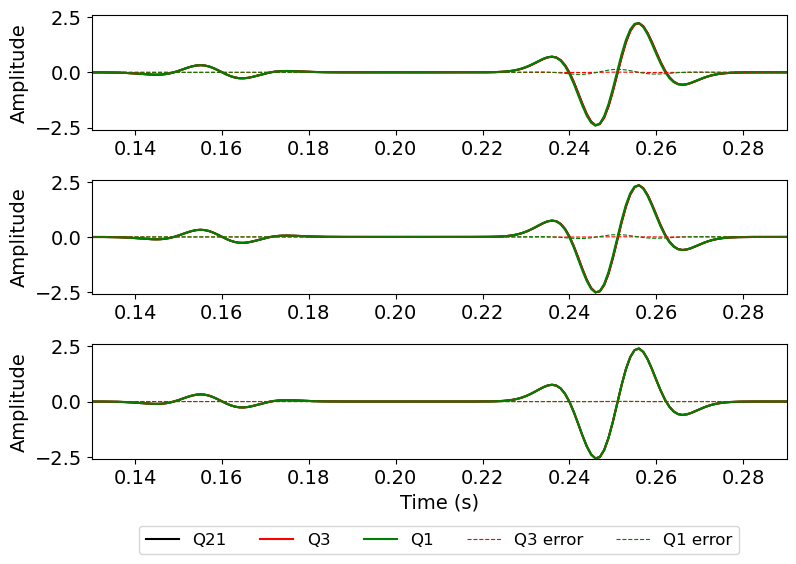

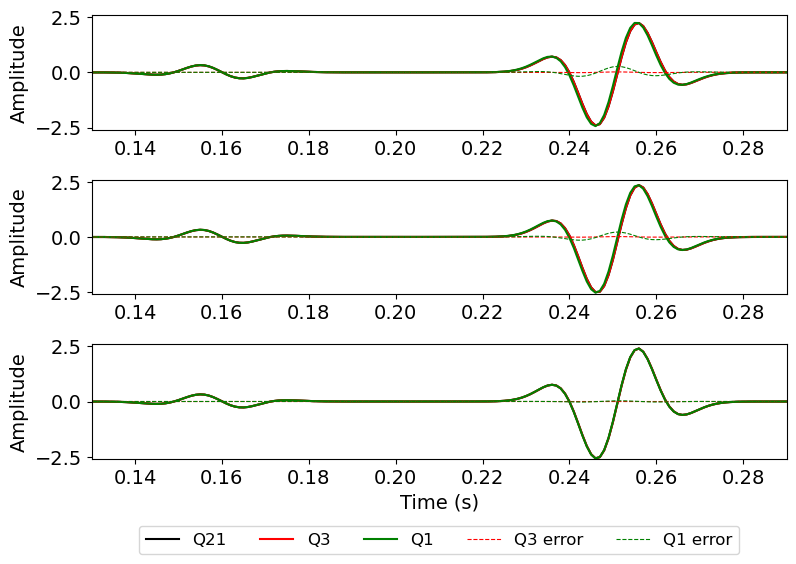

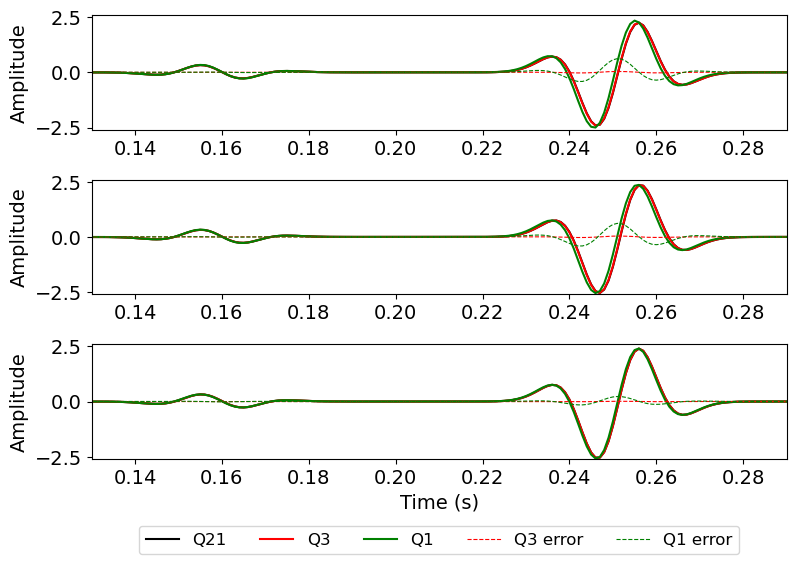

In [68]:
for GL in [10, 20, 50]:

    fig, axs = plt.subplots(3, 1, figsize=(8, 6))
    for i in range(ncable):
        true = DAS[f'Cable{i+1}_quad_21_GL{int(GL)}']
        waveform21 = DAS[f'Cable{i+1}_quad_21_GL{int(GL)}']
        waveform3 = DAS[f'Cable{i+1}_quad_3_GL{int(GL)}']
        waveform1 = DAS[f'Cable{i+1}_quad_1_GL{int(GL)}']

        plt.subplot(3, 1, i + 1)
        plt.plot(t, waveform21, color='black', linestyle='-', label = 'Q21', linewidth=1.5)
        plt.plot(t, waveform3,  color='red', linestyle='-', label = 'Q3', linewidth=1.5)
        plt.plot(t, waveform1,  color='green', linestyle='-', label = 'Q1', linewidth=1.5)
        plt.plot(t, waveform3-waveform21, color='red', linestyle='--', label = 'Q3 error', linewidth=0.8)
        plt.plot(t, waveform1-waveform21, color='green', linestyle='--', label = 'Q1 error', linewidth=0.8)
        
        # Add labels to each subplot
        # axs[0].text(-0.12, 1.2, 'a)', transform=axs[0].transAxes, fontsize=16, fontweight='bold', fontname='Times New Roman')
        # axs[1].text(-0.12, 1.2, 'b)', transform=axs[1].transAxes, fontsize=16, fontweight='bold', fontname='Times New Roman')
        # axs[2].text(-0.12, 1.2, 'c)', transform=axs[2].transAxes, fontsize=16, fontweight='bold', fontname='Times New Roman')

        clip = 2.6
        plt.xlim([0.13, 0.29])
        plt.ylim([-clip, clip])

        if i == 2:
            plt.xlabel('Time (s)', fontsize=14)
        plt.ylabel('Amplitude', fontsize=14)

    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.9), ncol=5, fontsize=12)
    plt.tight_layout()
    plt.savefig(f'./Fig/Fig-2-waveform-GL{GL}.png', dpi=300, )

In [66]:
# for g, GL in enumerate([10, 20, 50]):
#     fig = plt.figure(figsize=(12, 6))
#     for i in range(ncable):
#         true = DAS[f'Cable{i+1}_quad_21_GL{int(GL)}']

#         plt.subplot(3, 3, g * 3 + i + 1)
#         plt.plot(t, DAS[f'Cable{i+1}_quad_21_GL{int(GL)}'], 'k-', label = 'Q21', linewidth=1.5)
#         plt.plot(t, DAS[f'Cable{i+1}_quad_3_GL{int(GL)}'],  'r--', label = 'Q3', linewidth=1.5)
#         plt.plot(t, DAS[f'Cable{i+1}_quad_1_GL{int(GL)}'],  'b--', label = 'Q1', linewidth=1.5)

#         clip = 2.6
#         plt.xlim([0.12, 0.30])
#         plt.ylim([-clip, clip])

#         if g == 2:
#             plt.xlabel('Time (s)', fontsize=14)
#         if i == 0:
#             plt.ylabel('Amplitude', fontsize=14)

# # plt.legend(loc='center left', )
# plt.legend(loc="lower left", mode = "expand", ncol = 3, )
# plt.tight_layout()
# plt.savefig(f'./Fig/Fig-2-waveform.png', dpi=300, bbox_inches='tight')

In [67]:
# fig = plt.figure(figsize=(12, 6))
# for g, GL in enumerate([10, 20, 50]):
#     for i in range(ncable):
#         true = DAS[f'Cable{i+1}_quad_21_GL{int(GL)}']

#         plt.subplot(3, 3, g * 3 + i + 1)
#         plt.plot(t, DAS[f'Cable{i+1}_quad_21_GL{int(GL)}'] - true, 'k-', label = 'Q21', linewidth=1.5)
#         plt.plot(t, DAS[f'Cable{i+1}_quad_3_GL{int(GL)}'] - true,  'r--', label = 'Q3', linewidth=1.5)
#         plt.plot(t, DAS[f'Cable{i+1}_quad_1_GL{int(GL)}'] - true,  'b--', label = 'Q1', linewidth=1.5)

#         clip = 1.0
#         plt.xlim([0.12, 0.30])
#         plt.ylim([-clip, clip])

#         if g == 2:
#             plt.xlabel('Time (s)', fontsize=14)
#         if i == 0:
#             plt.ylabel('Amplitude', fontsize=14)

# # plt.legend(loc='center left', )
# plt.legend(loc="lower left", mode = "expand", ncol = 3, )
# plt.tight_layout()
# plt.savefig(f'./Fig/Fig-3-waveform-error.png', dpi=300, bbox_inches='tight')